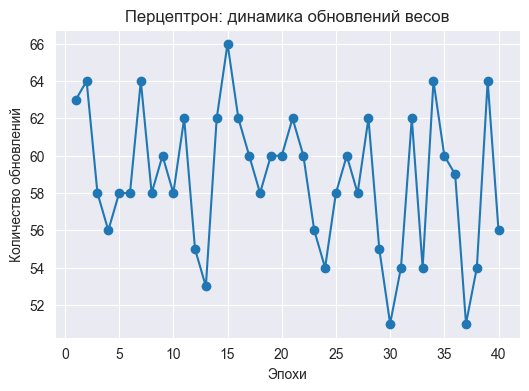

Accuracy (test): 85.96%
Precision: 0.9368 | Recall: 0.8318 | F1: 0.8812


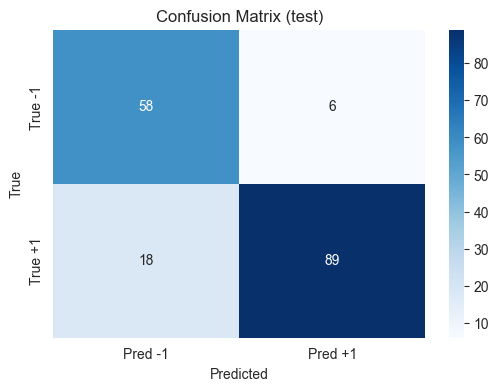

C:\Users\alesh\AppData\Local\Temp\ipykernel_21520\951377961.py:110: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


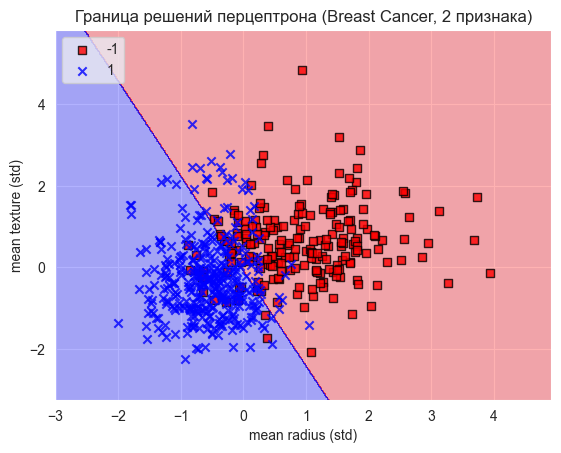

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


from sklearn.datasets import load_breast_cancer

def train_test_split_np(X, y, test_size=0.3, random_state=1, stratify=True):
    rng = np.random.RandomState(random_state)
    X = np.asarray(X); y = np.asarray(y)
    n = len(y)
    if stratify:
        idx_tr, idx_te = [], []
        for cls in np.unique(y):
            cls_idx = np.where(y == cls)[0]
            rng.shuffle(cls_idx)
            m_te = int(round(len(cls_idx) * test_size))
            idx_te.append(cls_idx[:m_te]); idx_tr.append(cls_idx[m_te:])
        idx_tr = np.concatenate(idx_tr); idx_te = np.concatenate(idx_te)
        rng.shuffle(idx_tr); rng.shuffle(idx_te)
    else:
        idx = np.arange(n); rng.shuffle(idx)
        m_te = int(round(n * test_size))
        idx_te, idx_tr = idx[:m_te], idx[m_te:]
    return X[idx_tr], X[idx_te], y[idx_tr], y[idx_te]

class StandardScalerNP:
    def fit(self, X):
        X = np.asarray(X)
        self.mean_ = X.mean(axis=0)
        self.std_  = X.std(axis=0)
        self.std_[self.std_ == 0.0] = 1.0
        return self
    def transform(self, X):
        X = np.asarray(X)
        return (X - self.mean_) / self.std_
    def fit_transform(self, X):
        return self.fit(X).transform(X)

def accuracy_np(y_true, y_pred):
    return float((y_true == y_pred).mean())

def confusion_matrix_np_pm(y_true, y_pred):

    tn = np.sum((y_true == -1) & (y_pred == -1))
    fp = np.sum((y_true == -1) & (y_pred ==  1))
    fn = np.sum((y_true ==  1) & (y_pred == -1))
    tp = np.sum((y_true ==  1) & (y_pred ==  1))
    return np.array([[tn, fp], [fn, tp]], dtype=int)

def precision_recall_f1_from_cm(cm):
    tn, fp = cm[0,0], cm[0,1]
    fn, tp = cm[1,0], cm[1,1]
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)
    return float(precision), float(recall), float(f1)


class Perceptron:
    def __init__(self, eta=0.1, n_iter=10, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])  # [bias, w1, w2, ...]
        self.errors_ = []
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0]  += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            return float(np.dot(X, self.w_[1:]) + self.w_[0])
        return X @ self.w_[1:] + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)


def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors  = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    x2_min, x2_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Z = classifier.predict(grid).reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max()); plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=[cmap(idx)],
                    marker=markers[idx], label=str(cl),
                    edgecolor='black')


bc = load_breast_cancer(as_frame=True)
df = bc.frame.copy()

feat1 = 'mean radius'
feat2 = 'mean texture'
X_all = df[[feat1, feat2]].values.astype(float)


y_all = np.where(df['target'].values == 1, 1, -1).astype(int)


X_tr, X_te, y_tr, y_te = train_test_split_np(X_all, y_all, test_size=0.3, random_state=1, stratify=True)

sc = StandardScalerNP()
X_tr_std = sc.fit_transform(X_tr)
X_te_std = sc.transform(X_te)


ppn = Perceptron(eta=0.01, n_iter=40, random_state=0)
ppn.fit(X_tr_std, y_tr)


plt.figure(figsize=(6, 4))
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Эпохи'); plt.ylabel('Количество обновлений')
plt.title('Перцептрон: динамика обновлений весов')
plt.grid(True)
plt.show()


y_pred_te = ppn.predict(X_te_std)
acc_te = accuracy_np(y_te, y_pred_te)
cm_te = confusion_matrix_np_pm(y_te, y_pred_te)
precision, recall, f1 = precision_recall_f1_from_cm(cm_te)

print(f"Accuracy (test): {acc_te*100:.2f}%")
print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm_te, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred -1', 'Pred +1'],
            yticklabels=['True -1', 'True +1'])
plt.title('Confusion Matrix (test)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


X_all_std = sc.transform(X_all)
plot_decision_regions(X_all_std, y_all, classifier=ppn)
plt.xlabel(f'{feat1} (std)'); plt.ylabel(f'{feat2} (std)')
plt.legend(loc='upper left'); plt.title('Граница решений перцептрона (Breast Cancer, 2 признака)')
plt.show()
